# BindingDB Data Cleaning and Formatting Script
BindingDB (https://www.bindingdb.org/rwd/bind/index.jsp#) is a public dataset with binding measurements for various protein-ligand interactions. This script is designed to clean and format the data for use in our training pipeline.

We can convert the IC50 values to a concentration and fraction bound using the following equation:

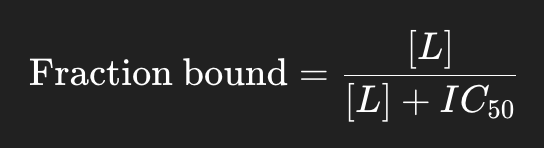

In [7]:
# References:
# https://pharmacologycanada.org/Cheng-Prusoff-equation#:~:text=Definition:,ligand%20and%20its%20binding%20partner.
# https://www.rdkit.org/docs/api-docs.html
# https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html
# https://biopython.org/docs/1.75/api/Bio.SeqUtils.html
# GitHub Copilot used for code completion in this script

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from Bio.SeqUtils import molecular_weight

max_unique_proteins = 50000
max_unique_glycans = 50000
binding_data_path = "../data/BindingDB_All.tsv"
num_rows = 10_000
seq_column = "BindingDB Target Chain Sequence"

binding_data = pd.read_csv(
    binding_data_path, nrows=num_rows, sep="\t", on_bad_lines="warn"
)
initial_total = len(binding_data)

# only use rows with IC50 values
binding_data["IC50 (nM)"] = pd.to_numeric(binding_data["IC50 (nM)"], errors="coerce")
filtered_data = binding_data.dropna(subset=["IC50 (nM)"]).copy()

# get unique proteins
protein_groups = filtered_data.dropna(subset=["BindingDB MonomerID"]).drop_duplicates(
    subset=["BindingDB MonomerID"]
)

# make sure proteins are valid by trying to load their molecular weight
valid_protein_rows = []
for idx, row in protein_groups.iterrows():
    seq = row[seq_column] if seq_column is not None else ""
    if not seq or pd.isna(seq):
        continue
    try:
        _ = molecular_weight(seq, seq_type="protein")
        valid_protein_rows.append(row)
    except Exception as e:
        continue
valid_protein_df = pd.DataFrame(valid_protein_rows)

if len(valid_protein_df) > max_unique_proteins:
    valid_protein_df = valid_protein_df.iloc[:max_unique_proteins]

# keep only the valid rows
valid_protein_ids = set(valid_protein_df["BindingDB MonomerID"])
filtered_data = filtered_data[
    filtered_data["BindingDB MonomerID"].isin(valid_protein_ids)
]

# rename the protein groups. The old names lead to parsing issues.
unique_protein_ids = sorted(valid_protein_ids)
protein_mapping = {orig: f"P_{i}" for i, orig in enumerate(unique_protein_ids, start=1)}

ligand_groups = filtered_data.dropna(subset=["BindingDB Ligand Name"]).drop_duplicates(
    subset=["BindingDB Ligand Name"]
)
initial_ligand_count = len(ligand_groups)
valid_ligand_rows = []

# make sure ligands are valid by trying to load their SMILES
fingerprint_generator = rdFingerprintGenerator.GetMorganGenerator()
for idx, row in ligand_groups.iterrows():
    smiles = row["Ligand SMILES"]
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
        _ = fingerprint_generator.GetFingerprint(mol)
        valid_ligand_rows.append(row)
    except Exception as e:
        continue
valid_ligand_df = pd.DataFrame(valid_ligand_rows)

if len(valid_ligand_df) > max_unique_glycans:
    valid_ligand_df = valid_ligand_df.iloc[:max_unique_glycans]

# rename the ligands. The old names lead to parsing issues.
valid_glycan_set = set(valid_ligand_df["BindingDB Ligand Name"])
glycan_mapping = {
    orig: f"G_{i}" for i, orig in enumerate(sorted(valid_glycan_set), start=1)
}

# create the data set
glycan_struct = pd.DataFrame(
    {
        "Name": valid_ligand_df["BindingDB Ligand Name"].map(glycan_mapping),
        "IUPAC": "NA",
        "SMILES": valid_ligand_df["Ligand SMILES"],
    }
)
glycan_struct.to_csv("BDB_Glycan-Structures-CFG611.txt", sep="\t", index=False)
print("Saved glycan structures to BDB_Glycan-Structures-CFG611.txt")

# expand each protein-ligand pair into multiple rows with concentrations from 0.01 to 200.
num_points = 10
concentration_values = np.linspace(0.01, 200, num_points)
train_rows = []
obj_id = 1
for _, row in filtered_data.iterrows():
    ic50 = row["IC50 (nM)"]
    protein_group_new = protein_mapping[row["BindingDB MonomerID"]]
    original_glycan = row["BindingDB Ligand Name"]
    for conc in concentration_values:
        f_value = conc / (ic50 + conc)
        train_rows.append(
            {
                "ObjId": obj_id,
                "ProteinGroup": protein_group_new,
                "Concentration": conc,
                "GlycanID": original_glycan,
                "f": f_value,
            }
        )
        obj_id += 1
train_fractions = pd.DataFrame(train_rows)

# remove rows with glycans that are not in the glycan set
initial_fraction_count = len(train_fractions)
train_fractions = train_fractions[train_fractions["GlycanID"].isin(valid_glycan_set)]
filtered_fraction_count = len(train_fractions)
train_fractions["GlycanID"] = train_fractions["GlycanID"].map(glycan_mapping)
train_fractions.to_csv("BDB_Train_Fractions.tsv", index=False, sep="\t")
print(
    f"Saved training fractions to BDB_Train_Fractions.tsv with {filtered_fraction_count} rows."
)

protein_seq = pd.DataFrame(
    {
        "ProteinGroup": valid_protein_df["BindingDB MonomerID"].map(protein_mapping),
        "Accession": valid_protein_df["BindingDB MonomerID"].astype(str),
        "Uniprot": valid_protein_df["Target Name"],
        "Amino Acid Sequence": (
            valid_protein_df[seq_column] if seq_column is not None else "NA"
        ),
    }
)
protein_seq.to_csv("BDB_Protein-Sequence-Table.txt", sep="\t", index=False)
print("Dataset creation complete.")

Saved glycan structures to BDB_Glycan-Structures-CFG611.txt
Saved training fractions to BDB_Train_Fractions.tsv with 74900 rows.
Dataset creation complete.
